# Оптимизация производственных расходов металлургического комбината "Стальная птица" при потребление электроэнергии на этапе обработки стали. 

## Описание проекта
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса.

## Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
-	`/datasets/data_arc_new.csv` — данные об электродах:
    -	key — номер партии;
    -	Начало нагрева дугой — время начала нагрева;
    -	Конец нагрева дугой — время окончания нагрева;
    -	Активная мощность — значение активной мощности;
    -	Реактивная мощность — значение реактивной мощности.


-	`/datasets/data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):
   -	key — номер партии;
   -	Bulk 1 … Bulk 15 — объём подаваемого материала.  


-	`/datasets/data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):
   -	key — номер партии;
   -	Bulk 1 … Bulk 15 — время подачи материала.

-	`/datasets/data_gas_new.csv` — данные о продувке сплава газом:
   -	key — номер партии;
   -	Газ 1 — объём подаваемого газа.

-	`/datasets/data_temp_new.csv` — результаты измерения температуры:
    -	key — номер партии;
    -	Время замера — время замера;
    -	Температура — значение температуры.


-	`/datasets/data_wire_new.csv` — данные о проволочных материалах (объём):
   -	key — номер партии;
   -	Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

-	`/datasets/data_wire_time_new.csv` — данные о проволочных материалах (время).
   -	key — номер партии;
   -	Wire 1 … Wire 15 — время подачи проволочных материалов.


Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы

1.	**Загрузка данных**  
Загрузим данные и выполним их первичный осмотр.
2.	**Исследовательский анализ и предобработка данных**  
Выполним исследовательский анализ каждого датафрейма и при необходимости выполним предобработку. Сделаем выводы об имеющихся признаках: понадобятся ли они для обучения моделей.
3.	**Объединение данных**  
Объединим выбранные нами признаки в один датафрейм по ключу.
4. **Исследовательский анализ и предобработка данных объединённого датафрейма**  
Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков и при необходимости выполним предобработку. Проведем корреляционный анализ. Мы можем использовать не только имеющиеся признаки, но и генерировать новые.
5. **Подготовка данных**  
Выполним подготовку данных для обучения модели. Разделим данные на две выборки, при масштабировании и кодировании учтем особенности данных и моделей.
6. **Обучение моделей машинного обучения**  
Обучим как минимум две модели. Хотя бы для одной из них подберем как минимум два гиперпараметра.
7. **Выбор лучшей модели**  
Выберем лучшую модель и проверим её качество на тестовой выборке.
8. **Общий вывод и рекомендации заказчику**  
Сделаем общий вывод о проделанной работе: опишем основные этапы работы, полученные результаты и дадим рекомендации для бизнеса.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Шаг 1: Загрузка данных

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [4]:
arc = pd.read_csv('/datasets/data_arc_new.csv')
display(arc.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [5]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [7]:
arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [8]:
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
display(bulk.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1,nan,nan,nan,43.000000,nan,nan,nan,nan,nan,nan,nan,206.000000,nan,150.000000,154.000000
2,nan,nan,nan,73.000000,nan,nan,nan,nan,nan,nan,nan,206.000000,nan,149.000000,154.000000
3,nan,nan,nan,34.000000,nan,nan,nan,nan,nan,nan,nan,205.000000,nan,152.000000,153.000000
4,nan,nan,nan,81.000000,nan,nan,nan,nan,nan,nan,nan,207.000000,nan,153.000000,154.000000
5,nan,nan,nan,78.000000,nan,nan,nan,nan,nan,nan,nan,203.000000,nan,151.000000,152.000000
6,nan,nan,nan,117.000000,nan,nan,nan,nan,nan,nan,nan,204.000000,nan,201.000000,154.000000
7,nan,nan,nan,117.000000,nan,nan,nan,nan,nan,nan,nan,204.000000,nan,152.000000,154.000000
8,nan,nan,nan,99.000000,nan,nan,nan,nan,nan,nan,nan,410.000000,nan,252.000000,153.000000
9,nan,nan,nan,117.000000,nan,nan,nan,nan,nan,nan,nan,107.000000,nan,99.000000,203.000000
10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,203.000000,nan,102.000000,204.000000


In [9]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [11]:
bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [12]:
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
display(bulk_time.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1,nan,nan,nan,2019-05-03 11:28:48,nan,nan,nan,nan,nan,nan,nan,2019-05-03 11:24:31,nan,2019-05-03 11:14:50,2019-05-03 11:10:43
2,nan,nan,nan,2019-05-03 11:36:50,nan,nan,nan,nan,nan,nan,nan,2019-05-03 11:53:30,nan,2019-05-03 11:48:37,2019-05-03 11:44:39
3,nan,nan,nan,2019-05-03 12:32:39,nan,nan,nan,nan,nan,nan,nan,2019-05-03 12:27:13,nan,2019-05-03 12:21:01,2019-05-03 12:16:16
4,nan,nan,nan,2019-05-03 12:43:22,nan,nan,nan,nan,nan,nan,nan,2019-05-03 12:58:00,nan,2019-05-03 12:51:11,2019-05-03 12:46:36
5,nan,nan,nan,2019-05-03 13:30:47,nan,nan,nan,nan,nan,nan,nan,2019-05-03 13:30:47,nan,2019-05-03 13:34:12,2019-05-03 13:30:47
6,nan,nan,nan,2019-05-03 13:57:27,nan,nan,nan,nan,nan,nan,nan,2019-05-03 13:48:52,nan,2019-05-03 14:09:42,2019-05-03 14:03:15
7,nan,nan,nan,2019-05-03 14:18:58,nan,nan,nan,nan,nan,nan,nan,2019-05-03 14:41:26,nan,2019-05-03 14:30:50,2019-05-03 14:27:16
8,nan,nan,nan,2019-05-03 15:17:58,nan,nan,nan,nan,nan,nan,nan,2019-05-03 15:17:58,nan,2019-05-03 15:13:18,2019-05-03 15:05:33
9,nan,nan,nan,2019-05-03 16:03:08,nan,nan,nan,nan,nan,nan,nan,2019-05-03 16:03:08,nan,2019-05-03 16:00:16,2019-05-03 15:52:39
10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2019-05-03 16:38:11,nan,2019-05-03 16:34:24,2019-05-03 16:29:56


In [13]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [15]:
bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [16]:
gas = pd.read_csv('/datasets/data_gas_new.csv')
display(gas.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Газ 1
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
6,11.273392
7,9.836267
8,15.171553
9,8.216623
10,6.529891


In [17]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [18]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [19]:
gas.isna().sum()

key      0
Газ 1    0
dtype: int64

In [20]:
temp = pd.read_csv('/datasets/data_temp_new.csv')
display(temp.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Время замера,Температура
1,2019-05-03 11:02:04,1571.000000
1,2019-05-03 11:07:18,1604.000000
1,2019-05-03 11:11:34,1618.000000
1,2019-05-03 11:18:04,1601.000000
1,2019-05-03 11:25:59,1606.000000
1,2019-05-03 11:30:38,1613.000000
2,2019-05-03 11:34:04,1581.000000
2,2019-05-03 11:38:40,1577.000000
2,2019-05-03 11:46:09,1589.000000
2,2019-05-03 11:49:38,1604.000000


In [21]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [22]:
temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [23]:
temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

***Наблюдаем значительное количество пропусков в замере температуры в ковше. Учтем этот момент в дальнейшем исследовательском анализе.***

In [24]:
wire = pd.read_csv('/datasets/data_wire_new.csv')
display(wire.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1,60.059998,nan,nan,nan,nan,nan,nan,nan,nan
2,96.052315,nan,nan,nan,nan,nan,nan,nan,nan
3,91.160157,nan,nan,nan,nan,nan,nan,nan,nan
4,89.063515,nan,nan,nan,nan,nan,nan,nan,nan
5,89.238236,9.114560,nan,nan,nan,nan,nan,nan,nan
6,99.109917,9.114560,nan,nan,nan,nan,nan,nan,nan
7,98.061600,nan,nan,nan,nan,nan,nan,nan,nan
8,155.282394,nan,nan,nan,nan,nan,nan,nan,nan
9,113.393279,9.143681,nan,nan,nan,nan,nan,nan,nan
10,81.244796,12.376000,nan,nan,nan,nan,nan,nan,nan


In [25]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [26]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [27]:
wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [28]:
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
display(wire_time.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1,2019-05-03 11:06:19,nan,nan,nan,nan,nan,nan,nan,nan
2,2019-05-03 11:36:50,nan,nan,nan,nan,nan,nan,nan,nan
3,2019-05-03 12:11:46,nan,nan,nan,nan,nan,nan,nan,nan
4,2019-05-03 12:43:22,nan,nan,nan,nan,nan,nan,nan,nan
5,2019-05-03 13:20:44,2019-05-03 13:15:34,nan,nan,nan,nan,nan,nan,nan
6,2019-05-03 13:57:27,2019-05-03 13:48:52,nan,nan,nan,nan,nan,nan,nan
7,2019-05-03 14:18:58,nan,nan,nan,nan,nan,nan,nan,nan
8,2019-05-03 15:01:30,nan,nan,nan,nan,nan,nan,nan,nan
9,2019-05-03 15:45:44,2019-05-03 15:39:37,nan,nan,nan,nan,nan,nan,nan
10,2019-05-03 16:27:00,2019-05-03 16:22:36,nan,nan,nan,nan,nan,nan,nan


In [29]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [30]:
wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [31]:
wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

### Вывод

- Провели загрузку данных. Имена столбцов достаточно информативны и их не переименовывали.
- Обнаружили пропуски в данных, что свидетельствует об отсутсвии использования в технологическом процессе данного материала и в дальнейшем целесообразно заполнить значение на "0".

## Шаг 2: Исследовательский анализ и предобработка данных

In [32]:
def range_diagram(file, column, title):
    fig, axes = plt.subplots(figsize=(28, 8))
    file.boxplot(column, vert=False, patch_artist = True, boxprops = dict(facecolor = "blue"), grid= False, fontsize=14, color='blue')
    plt.suptitle(title, fontsize=20, fontweight="bold", color='blue')
    plt.yticks(rotation=90, fontsize=16, fontweight="bold", color='blue')
    plt.show()

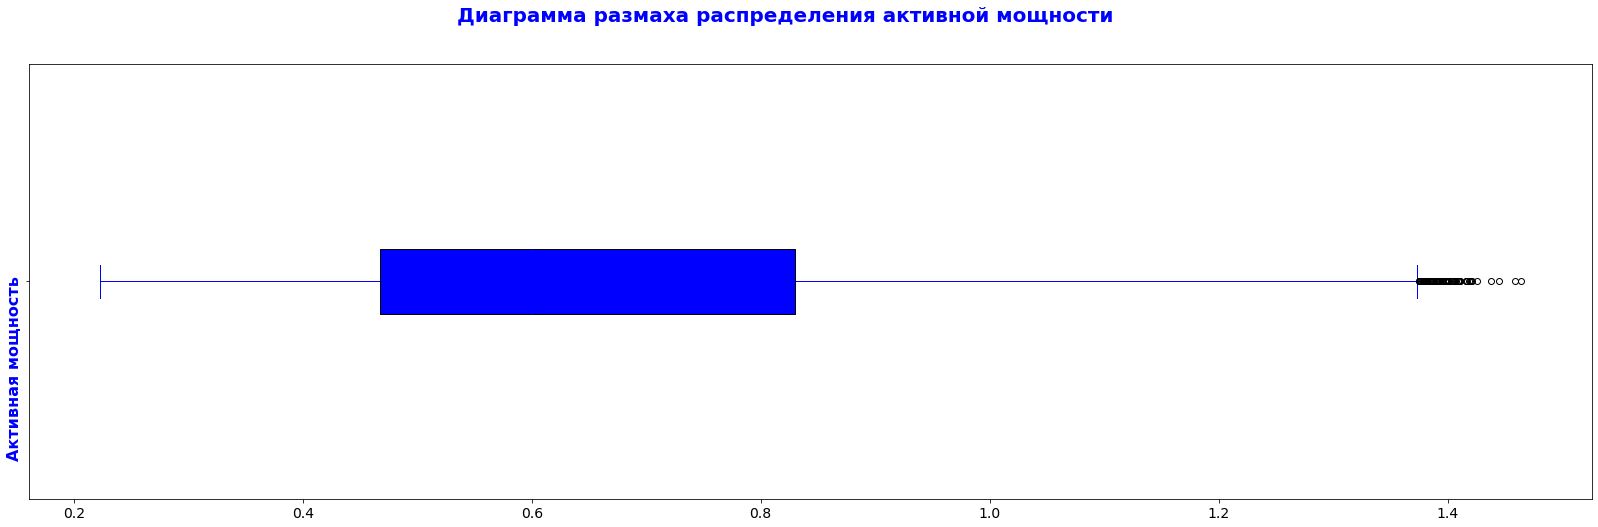

In [33]:
file=arc
column='Активная мощность'
title='Диаграмма размаха распределения активной мощности'
range_diagram(file, column, title)

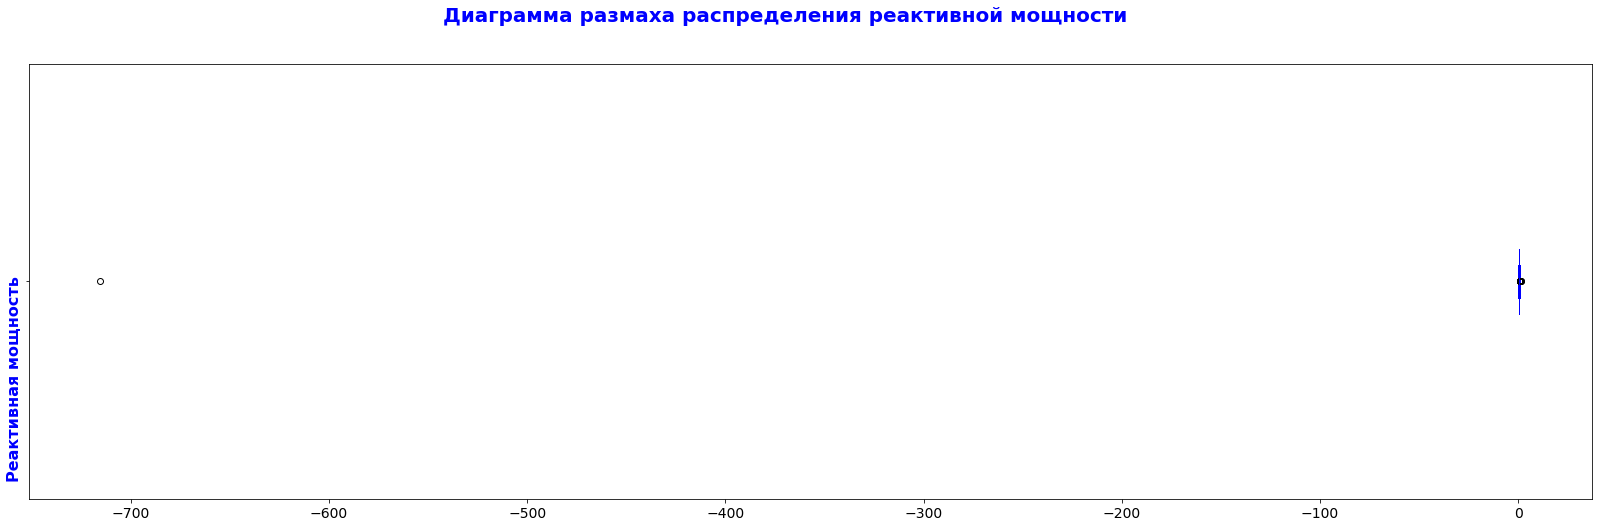

In [34]:
file=arc
column='Реактивная мощность'
title='Диаграмма размаха распределения реактивной мощности'
range_diagram(file, column, title)

***Обнаружили выброс в данных реактивной мощности в отрицательном диапазоне. Удалим партии в которых имеются такие значения.***

In [35]:
display(arc.loc[arc['Реактивная мощность'] < 0].style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [36]:
arc = arc.loc[arc['key'] != 2116]

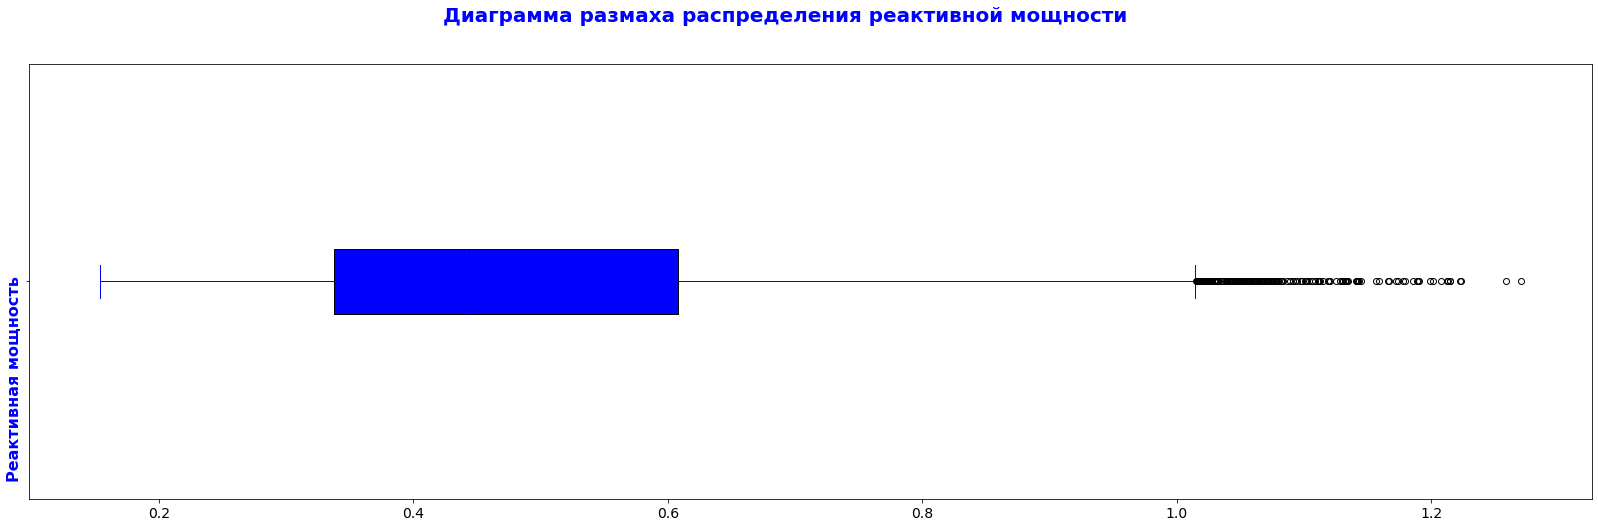

In [37]:
file=arc
column='Реактивная мощность'
title='Диаграмма размаха распределения реактивной мощности'
range_diagram(file, column, title)

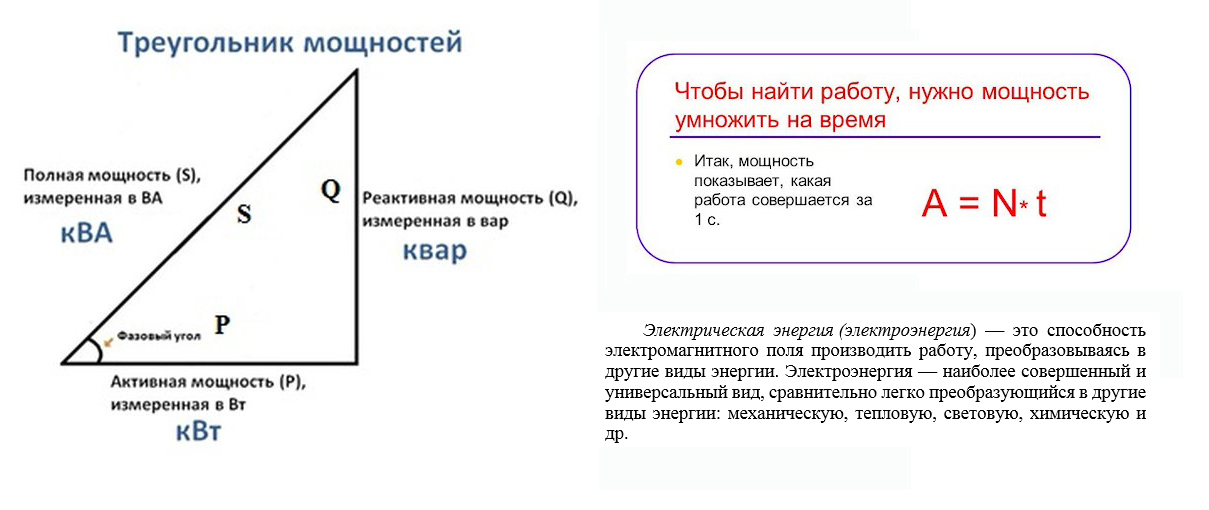

***Полная мощность равна геометрической сумме векторов активной и реактивной мощностей. Эти вектора перпендикулярны и посчитаем полную мощность по формуле. Посчитаем время затраченное на каждое включение на нагрев и работу (затраты электроэнергии) на каждое включение.***

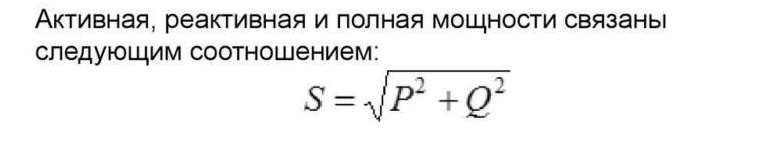

In [38]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
arc['Полная мощность'] = (arc['Активная мощность']**2 + arc['Реактивная мощность']**2)**(0.5)
arc['Время нагрева дугой'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).astype('timedelta64[s]')
arc['Время нагрева дугой'] = arc['Время нагрева дугой'].astype(int)
arc['Затраты электроэнергии'] = arc['Полная мощность']*arc['Время нагрева дугой']

***Для каждой партии посчитаем среднее значение мощности. Посчитаем затраченную электроэнергию суммировав затраты на каждую партию.***

In [39]:
arc_columns = {
    'key'            : 'count', 
    'Начало нагрева дугой' : 'min',
    'Конец нагрева дугой' : 'max',
    'Активная мощность'   : 'mean',
    'Реактивная мощность' : 'mean',
    'Полная мощность'    : 'mean',
    'Время нагрева дугой' : 'sum',
    'Затраты электроэнергии' : 'sum'
}
arc = arc.groupby('key').agg(arc_columns).rename(columns={'key':'Количество циклов нагрева'})

In [40]:
arc_time = arc[['Начало нагрева дугой', 'Конец нагрева дугой']]
display(arc_time.head(10).style.background_gradient(cmap='Blues', axis=0))

,Начало нагрева дугой,Конец нагрева дугой
key,,
1,2019-05-03 11:02:14,2019-05-03 11:28:37
2,2019-05-03 11:34:14,2019-05-03 11:53:18
3,2019-05-03 12:06:54,2019-05-03 12:32:19
4,2019-05-03 12:39:37,2019-05-03 12:57:50
5,2019-05-03 13:11:13,2019-05-03 13:33:55
6,2019-05-03 13:46:51,2019-05-03 14:09:24
7,2019-05-03 14:16:46,2019-05-03 14:41:15
8,2019-05-03 14:53:56,2019-05-03 15:17:48
9,2019-05-03 15:36:43,2019-05-03 16:02:49


In [41]:
arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis= 1 , inplace= True ) 
display(arc.head(10).style.background_gradient(cmap='Blues', axis=0))

,Количество циклов нагрева,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Затраты электроэнергии
key,,,,,,
1,5,0.607346,0.428564,0.743747,1098,770.282114
2,4,0.534852,0.363339,0.647087,811,481.760005
3,5,0.812728,0.587491,1.003845,655,722.837668
4,4,0.676622,0.514248,0.850010,741,683.455597
5,4,0.563238,0.421998,0.704245,869,512.169934
6,4,0.681318,0.470328,0.828269,952,839.231310
7,4,0.656719,0.490105,0.820978,673,613.576982
8,4,0.669740,0.524238,0.851489,913,619.129542
9,5,0.704164,0.505473,0.867052,625,570.113675


In [42]:
len_arc = len(arc)

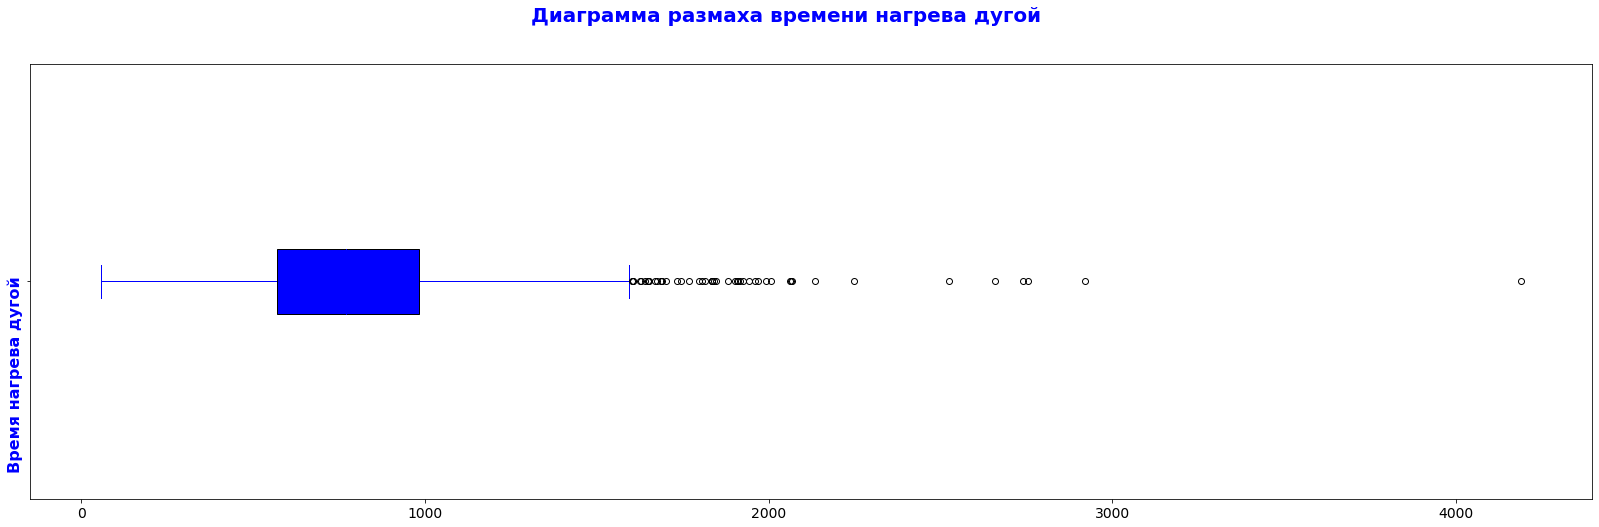

In [43]:
file=arc
column='Время нагрева дугой'
title='Диаграмма размаха времени нагрева дугой'
range_diagram(file, column, title)

In [44]:
arc['Время нагрева дугой'].describe()

count    3213.000000
mean      794.691566
std       332.439136
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: Время нагрева дугой, dtype: float64

***Наблюдаем некоторое количество аномально больших значений суммарного времени нагрева по каждой партии. Изучим партии с временем более 2000 с.***

In [45]:
display(arc.loc[arc['Время нагрева дугой'] > 2000].sort_values(by='Количество циклов нагрева', 
                                                               ascending=False).style.background_gradient(cmap='Blues', axis=0))

,Количество циклов нагрева,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Затраты электроэнергии
key,,,,,,
2108,16,0.669175,0.474343,0.820929,2739,2151.752807
1513,15,0.775490,0.571533,0.964436,2526,2380.879281
1689,15,0.825042,0.596603,1.019218,4189,4546.405812
46,13,0.706174,0.542457,0.891672,2919,2306.073920
322,13,0.685754,0.504934,0.851966,2658,2026.007227
44,12,0.608250,0.435102,0.748429,2063,1393.802417
638,11,0.661000,0.452892,0.801596,2067,1654.779561
1880,11,0.559006,0.387556,0.680447,2755,1851.427463
2917,11,0.586461,0.453019,0.741930,2006,1224.527008


***Данные по времени нагрева дугой в партии №1689 считаем аномиально большими. Видимо добиваясь требуемого качества, приходилолсь значительно повторять цикл и время нагрева. Эти данные считаем выбросом и удалим.***

In [46]:
arc = arc.loc[arc['Время нагрева дугой'] < 3000]

In [47]:
arc['Затраты электроэнергии'].describe()

count    3212.000000
mean      654.477577
std       301.270905
min        33.430208
25%       444.785195
50%       620.101427
75%       827.446306
max      2380.879281
Name: Затраты электроэнергии, dtype: float64

In [48]:
def bar_chart(file, column, title, xlabel, ylabel, bins):

    ax = file[column].plot(kind='hist', bins=bins, grid=False, color='blue', figsize=(28,10))
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", color='blue')
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", color='blue')
    ax.set_title(title, fontsize=16, fontweight="bold", color='blue')

None

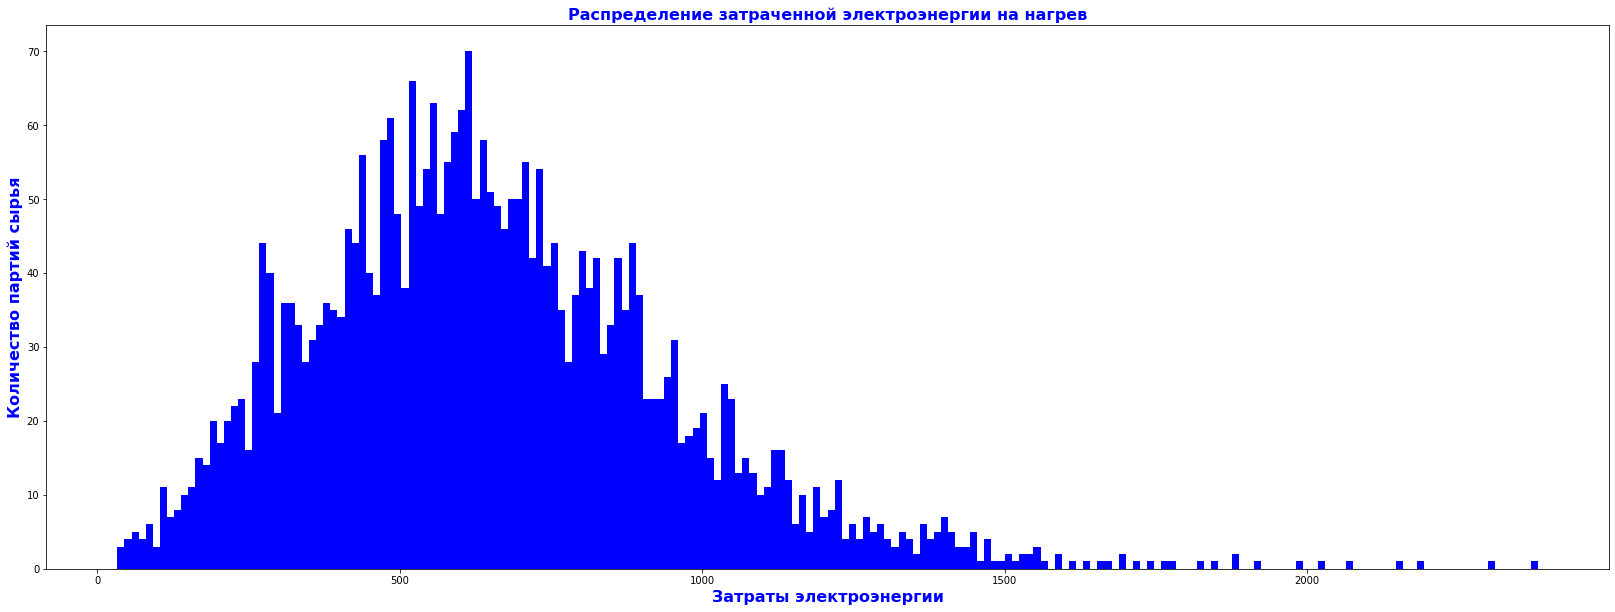

In [49]:
file=arc
column='Затраты электроэнергии'
title='Распределение затраченной электроэнергии на нагрев'
xlabel='Затраты электроэнергии'
ylabel='Количество партий сырья'
bins=200
bar_chart(file, column, title, xlabel, ylabel, bins)

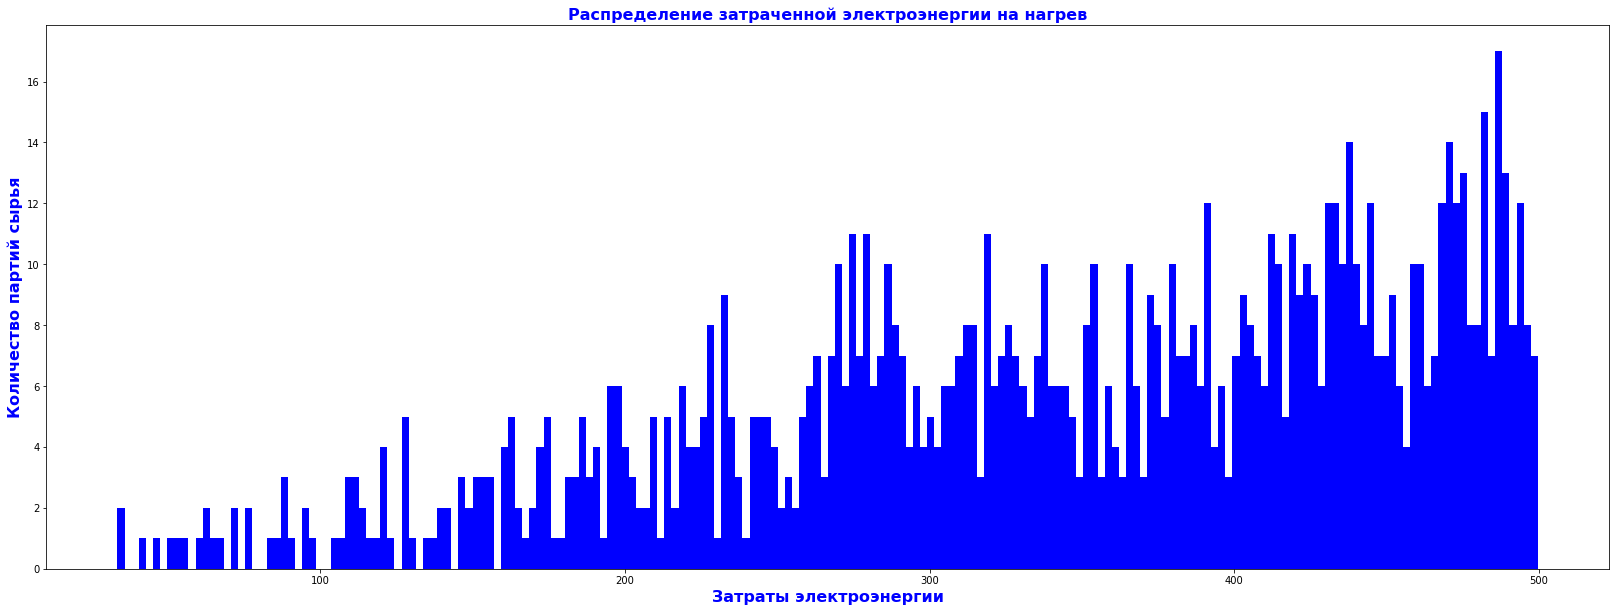

In [50]:
file=arc.loc[arc['Затраты электроэнергии'] < 500]
column='Затраты электроэнергии'
title='Распределение затраченной электроэнергии на нагрев'
xlabel='Затраты электроэнергии'
ylabel='Количество партий сырья'
bins=200
bar_chart(file, column, title, xlabel, ylabel, bins)

***Введем дополнительный признак `Bulk sum` общего объема добавленного сыпучего материала в расплав.***

In [51]:
bulk = bulk.fillna(0)
bulk['Bulk sum'] = bulk.sum(axis=1)
bulk = bulk.astype(int)
display(bulk.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk sum
1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,554
2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,584
3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,547
4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,599
5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,589
6,0,0,0,117,0,0,0,0,0,0,0,204,0,201,154,682
7,0,0,0,117,0,0,0,0,0,0,0,204,0,152,154,634
8,0,0,0,99,0,0,0,0,0,0,0,410,0,252,153,922
9,0,0,0,117,0,0,0,0,0,0,0,107,0,99,203,535
10,0,0,0,0,0,0,0,0,0,0,0,203,0,102,204,519


***Отметим время первого и последнего замера температуры.***

In [52]:
display(temp.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Время замера,Температура
1,2019-05-03 11:02:04,1571.000000
1,2019-05-03 11:07:18,1604.000000
1,2019-05-03 11:11:34,1618.000000
1,2019-05-03 11:18:04,1601.000000
1,2019-05-03 11:25:59,1606.000000
1,2019-05-03 11:30:38,1613.000000
2,2019-05-03 11:34:04,1581.000000
2,2019-05-03 11:38:40,1577.000000
2,2019-05-03 11:46:09,1589.000000
2,2019-05-03 11:49:38,1604.000000


In [53]:
temp_time = temp
temp_time['Время начального замера температуры'] = temp_time['Время замера']
temp_time['Время последнего замера температуры'] = temp_time['Время замера']
temp_time_columns = {'Время начального замера температуры' : 'first', 'Время последнего замера температуры' : 'last'}
temp_time = temp_time.groupby('key').agg(temp_time_columns)
display(temp_time.head(10).style.background_gradient(cmap='Blues', axis=0))

,Время начального замера температуры,Время последнего замера температуры
key,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38
2,2019-05-03 11:34:04,2019-05-03 11:55:09
3,2019-05-03 12:06:44,2019-05-03 12:35:57
4,2019-05-03 12:39:27,2019-05-03 12:59:47
5,2019-05-03 13:11:03,2019-05-03 13:36:39
6,2019-05-03 13:46:41,2019-05-03 14:11:38
7,2019-05-03 14:16:36,2019-05-03 14:45:40
8,2019-05-03 14:53:46,2019-05-03 15:20:41
9,2019-05-03 15:36:33,2019-05-03 16:06:44


In [54]:
temp_time.isnull().sum().sum()

0

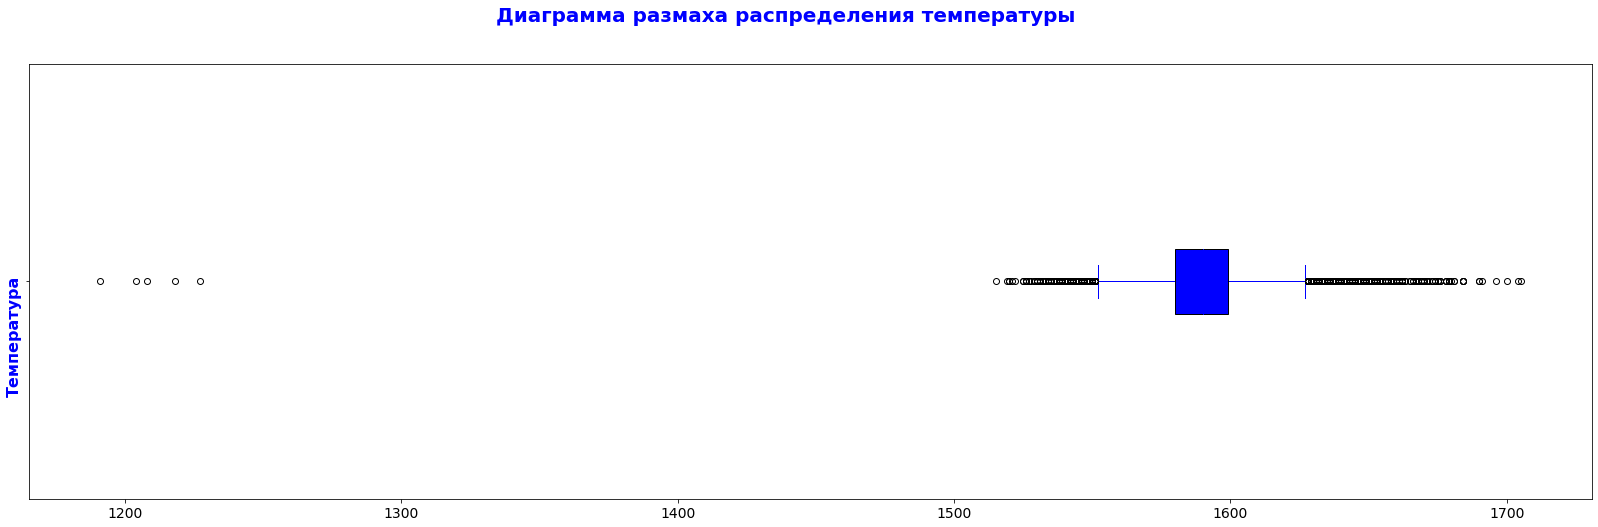

In [55]:
file=temp
column='Температура'
title='Диаграмма размаха распределения температуры'
range_diagram(file, column, title)

***Удалим те партии, в которых наблюдались пропуски в замерах температуры. Заменим пропуски в значениях температуры на "0".***

In [56]:
temp = temp.fillna(0)

***Температура нагрева по регламенту не должна опускаться ниже 1400 градусов. https://hardhub.ru/articles/stali/sposoby-proizvodstva-stali/
Удалим те партии в процессе производства которых температура в ковше опускалась ниже этого значения. В тех партиях, в которых пропуски заменили на "0", минимальное значение температуры будет равно "0". Удалим одновременно и эти партии.***

In [57]:
temp['Начальная температура'] = temp['Температура']
temp['Минимальная температура'] = temp['Температура']
temp['Окончательная температура'] = temp['Температура']
temp_columns = {'Начальная температура' : 'first', 'Минимальная температура' : 'min', 'Окончательная температура' : 'last'}
temp = temp.groupby('key').agg(temp_columns)
temp['Начальная температура'] = temp['Начальная температура'].astype(int)
temp['Минимальная температура'] = temp['Минимальная температура'].astype(int)
temp['Окончательная температура'] = temp['Окончательная температура'].astype(int)
temp = temp.loc[temp['Минимальная температура'] > 1400]
display(temp.head(10).style.background_gradient(cmap='Blues', axis=0))

,Начальная температура,Минимальная температура,Окончательная температура
key,,,
1,1571,1571,1613
2,1581,1577,1602
3,1596,1596,1599
4,1601,1601,1625
5,1576,1576,1602
6,1543,1543,1596
7,1586,1582,1599
8,1577,1577,1598
9,1587,1586,1592


In [58]:
temp.describe()

,Начальная температура,Минимальная температура,Окончательная температура
count,2473.000000,2473.000000,2473.000000
mean,1589.016175,1578.854832,1595.338051
std,24.996127,18.316249,16.031388
min,1519.000000,1519.000000,1541.000000
25%,1572.000000,1569.000000,1587.000000
50%,1588.000000,1579.000000,1593.000000
75%,1605.000000,1589.000000,1599.000000
max,1679.000000,1661.000000,1700.000000


In [59]:
temp.isna().sum()

Начальная температура        0
Минимальная температура      0
Окончательная температура    0
dtype: int64

***Окончательная температура является целевым признаком по требованию заказчика. Пропусков в этих значениях не наблюдаем.***

In [60]:
wire = wire.fillna(0)
display(wire.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1,60.059998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,96.052315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,91.160157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,89.063515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,89.238236,9.114560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,99.109917,9.114560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,98.061600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,155.282394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,113.393279,9.143681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,81.244796,12.376000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Шаг 3: Объединение данных

***По регламенту производственного процесса операция замера температуры в начале и в конце каждого этапа должны быть соответсвенно первой и последней операцией. Создадим для этого таблицу данных. Удалим те партии в которых был нарушен этот процесс.***

In [61]:
time_names = [arc_time, bulk_time, wire_time]
total_time = temp_time
for i in time_names:
    total_time = total_time.merge(i, on=['key'])

In [62]:
total_time['Время последнего замера температуры'] = pd.to_datetime(total_time['Время последнего замера температуры'])
total_time['Время начального замера температуры'] = pd.to_datetime(total_time['Время начального замера температуры'])
total_time['Конец нагрева дугой'] = pd.to_datetime(total_time['Конец нагрева дугой'])
total_time['Начало нагрева дугой'] = pd.to_datetime(total_time['Начало нагрева дугой'])
for i in range(1,16):
    total_time['Bulk ' + str(i)] = pd.to_datetime(total_time['Bulk ' + str(i)])
for i in range(1,10):
    total_time['Wire ' + str(i)] = pd.to_datetime(total_time['Wire ' + str(i)])

In [63]:
display(total_time.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Время начального замера температуры,Время последнего замера температуры,Начало нагрева дугой,Конец нагрева дугой,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1,2019-05-03 11:02:04,2019-05-03 11:30:38,2019-05-03 11:02:14,2019-05-03 11:28:37,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:34:04,2019-05-03 11:55:09,2019-05-03 11:34:14,2019-05-03 11:53:18,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:06:44,2019-05-03 12:35:57,2019-05-03 12:06:54,2019-05-03 12:32:19,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:39:27,2019-05-03 12:59:47,2019-05-03 12:39:37,2019-05-03 12:57:50,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:11:03,2019-05-03 13:36:39,2019-05-03 13:11:13,2019-05-03 13:33:55,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,2019-05-03 13:46:41,2019-05-03 14:11:38,2019-05-03 13:46:51,2019-05-03 14:09:24,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,2019-05-03 14:16:36,2019-05-03 14:45:40,2019-05-03 14:16:46,2019-05-03 14:41:15,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,2019-05-03 14:53:46,2019-05-03 15:20:41,2019-05-03 14:53:56,2019-05-03 15:17:48,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,2019-05-03 15:13:18,2019-05-03 15:05:33,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,2019-05-03 15:36:33,2019-05-03 16:06:44,2019-05-03 15:36:43,2019-05-03 16:02:49,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,2019-05-03 16:00:16,2019-05-03 15:52:39,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
10,2019-05-03 16:13:59,2019-05-03 16:39:50,2019-05-03 16:14:09,2019-05-03 16:37:51,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:38:11,NaT,2019-05-03 16:34:24,2019-05-03 16:29:56,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [64]:
total_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023 entries, 0 to 3022
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   key                                  3023 non-null   int64         
 1   Время начального замера температуры  3023 non-null   datetime64[ns]
 2   Время последнего замера температуры  3023 non-null   datetime64[ns]
 3   Начало нагрева дугой                 3023 non-null   datetime64[ns]
 4   Конец нагрева дугой                  3023 non-null   datetime64[ns]
 5   Bulk 1                               252 non-null    datetime64[ns]
 6   Bulk 2                               22 non-null     datetime64[ns]
 7   Bulk 3                               1293 non-null   datetime64[ns]
 8   Bulk 4                               1013 non-null   datetime64[ns]
 9   Bulk 5                               77 non-null     datetime64[ns]
 10  Bulk 6      

In [65]:
total_time.isna().sum()

key                                       0
Время начального замера температуры       0
Время последнего замера температуры       0
Начало нагрева дугой                      0
Конец нагрева дугой                       0
Bulk 1                                 2771
Bulk 2                                 3001
Bulk 3                                 1730
Bulk 4                                 2010
Bulk 5                                 2946
Bulk 6                                 2453
Bulk 7                                 2999
Bulk 8                                 3022
Bulk 9                                 3004
Bulk 10                                2847
Bulk 11                                2846
Bulk 12                                 665
Bulk 13                                3005
Bulk 14                                 313
Bulk 15                                 787
Wire 1                                   25
Wire 2                                 1972
Wire 3                          

In [66]:
total_time_columns = total_time.select_dtypes('datetime').columns
total_time_columns

Index(['Время начального замера температуры',
       'Время последнего замера температуры', 'Начало нагрева дугой',
       'Конец нагрева дугой', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [67]:
total_time['max'] = total_time['Время последнего замера температуры'] >= total_time[total_time_columns].max(axis=1)
max_time = len(total_time[total_time['max'] == False][total_time_columns])

print('\u001b[38;5;19m','Количество партий с нарушением времени замера температуры в конце каждого этапа равны', max_time, '\u001b[0m')

 Количество партий с нарушением времени замера температуры в конце каждого этапа равны 0 


In [68]:
total_time['min'] = total_time['Время начального замера температуры'] <= total_time[total_time_columns].min(axis=1)
min_time = len(total_time[total_time['min'] == False][total_time_columns])

print('\u001b[38;5;19m','Количество партий с нарушением времени замера температуры в начале каждого этапа равны', min_time, '\u001b[0m')

 Количество партий с нарушением времени замера температуры в начале каждого этапа равны 0 


***Создадим основной общий датафрейм объеденив данные по ключу 'key'.***

In [69]:
data_names = [bulk, gas, temp, wire]
total = arc
for data in data_names:
    total = total.merge(data, on=['key'])
display(total.head(10).style.background_gradient(cmap='Blues', axis=0).hide_index())

key,Количество циклов нагрева,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Затраты электроэнергии,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk sum,Газ 1,Начальная температура,Минимальная температура,Окончательная температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1,5,0.607346,0.428564,0.743747,1098,770.282114,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,554,29.749986,1571,1571,1613,60.059998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4,0.534852,0.363339,0.647087,811,481.760005,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,584,12.555561,1581,1577,1602,96.052315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5,0.812728,0.587491,1.003845,655,722.837668,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,547,28.554793,1596,1596,1599,91.160157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.676622,0.514248,0.850010,741,683.455597,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,599,18.841219,1601,1601,1625,89.063515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,4,0.563238,0.421998,0.704245,869,512.169934,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,589,5.413692,1576,1576,1602,89.238236,9.114560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,4,0.681318,0.470328,0.828269,952,839.231310,0,0,0,117,0,0,0,0,0,0,0,204,0,201,154,682,11.273392,1543,1543,1596,99.109917,9.114560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,4,0.656719,0.490105,0.820978,673,613.576982,0,0,0,117,0,0,0,0,0,0,0,204,0,152,154,634,9.836267,1586,1582,1599,98.061600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,4,0.669740,0.524238,0.851489,913,619.129542,0,0,0,99,0,0,0,0,0,0,0,410,0,252,153,922,15.171553,1577,1577,1598,155.282394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,5,0.704164,0.505473,0.867052,625,570.113675,0,0,0,117,0,0,0,0,0,0,0,107,0,99,203,535,8.216623,1587,1586,1592,113.393279,9.143681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,6,0.519796,0.359157,0.631834,825,533.482050,0,0,0,0,0,0,0,0,0,0,0,203,0,102,204,519,6.529891,1574,1574,1593,81.244796,12.376000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [70]:
excess = (len_arc - len(total.merge(total_time, on=['key'])))/len_arc*100
print('\u001b[38;5;19m','После предобработки были удалены', "%.1f%%" % excess, 'исходных данных', '\u001b[0m')

 После предобработки были удалены 27.7% исходных данных 


***Объеденили данные в 2 таблицы по времени и без учета времени проведения работ. Проверили на корректность операции по замеру температуры в начале и в конце каждого этапа. Определили, что по завершению этапа предобработки были удалены 27.7% исходных данных.***

## Шаг 4: Исследовательский анализ и предобработка данных объединённого датафрейма

In [71]:
corr_data=pd.Series()
for i in total.columns:
    corr_data[i] = abs(total['Окончательная температура'].corr(total[i]))
corr_data= corr_data.sort_values(ascending=False)[1:]

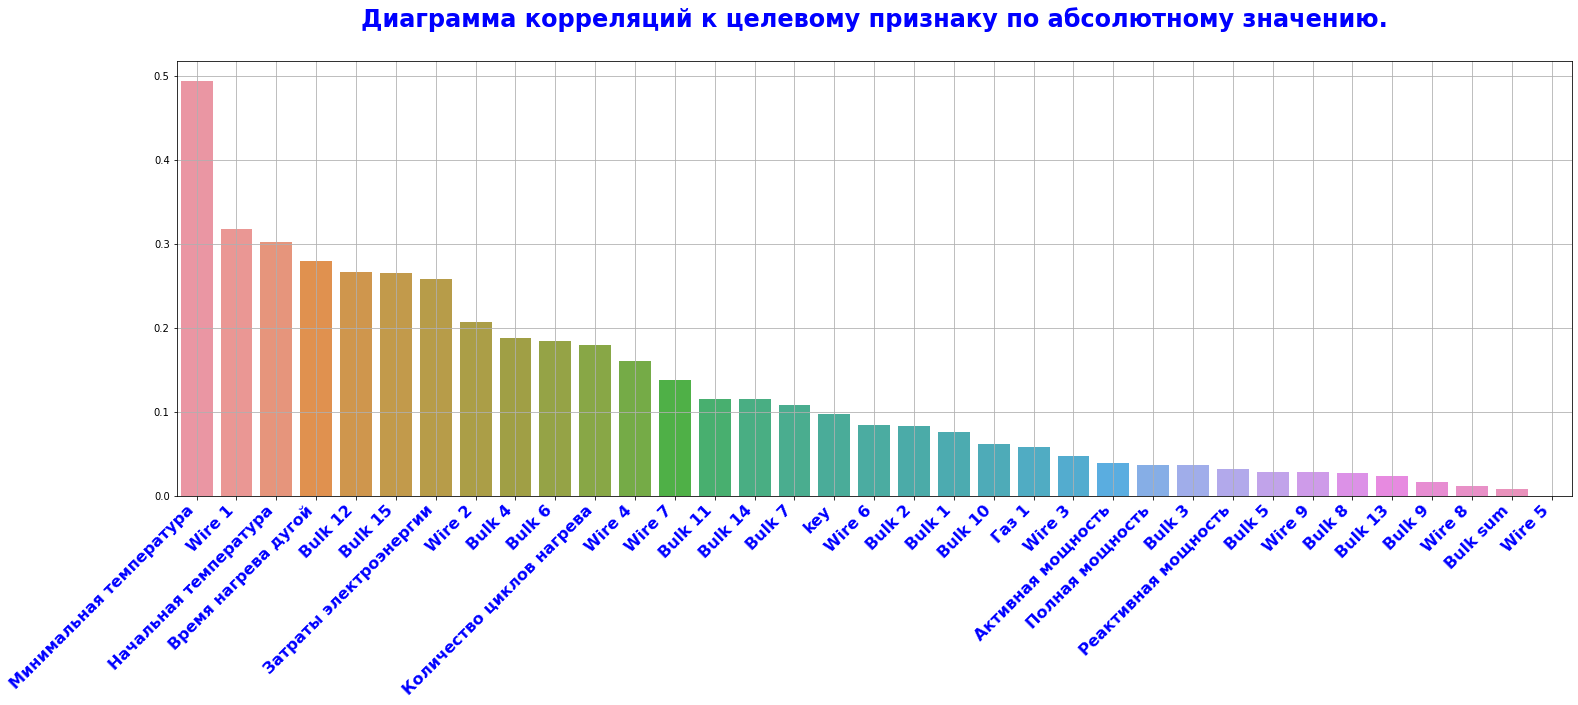

In [72]:
plt.figure(figsize=(25,8))
sns.barplot(x=corr_data.index, y=corr_data.values)
plt.title('Диаграмма корреляций к целевому признаку по абсолютному значению.\n ', fontsize=24, fontweight="bold", color='blue')
plt.grid()
plt.xticks(rotation=45, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
plt.show()

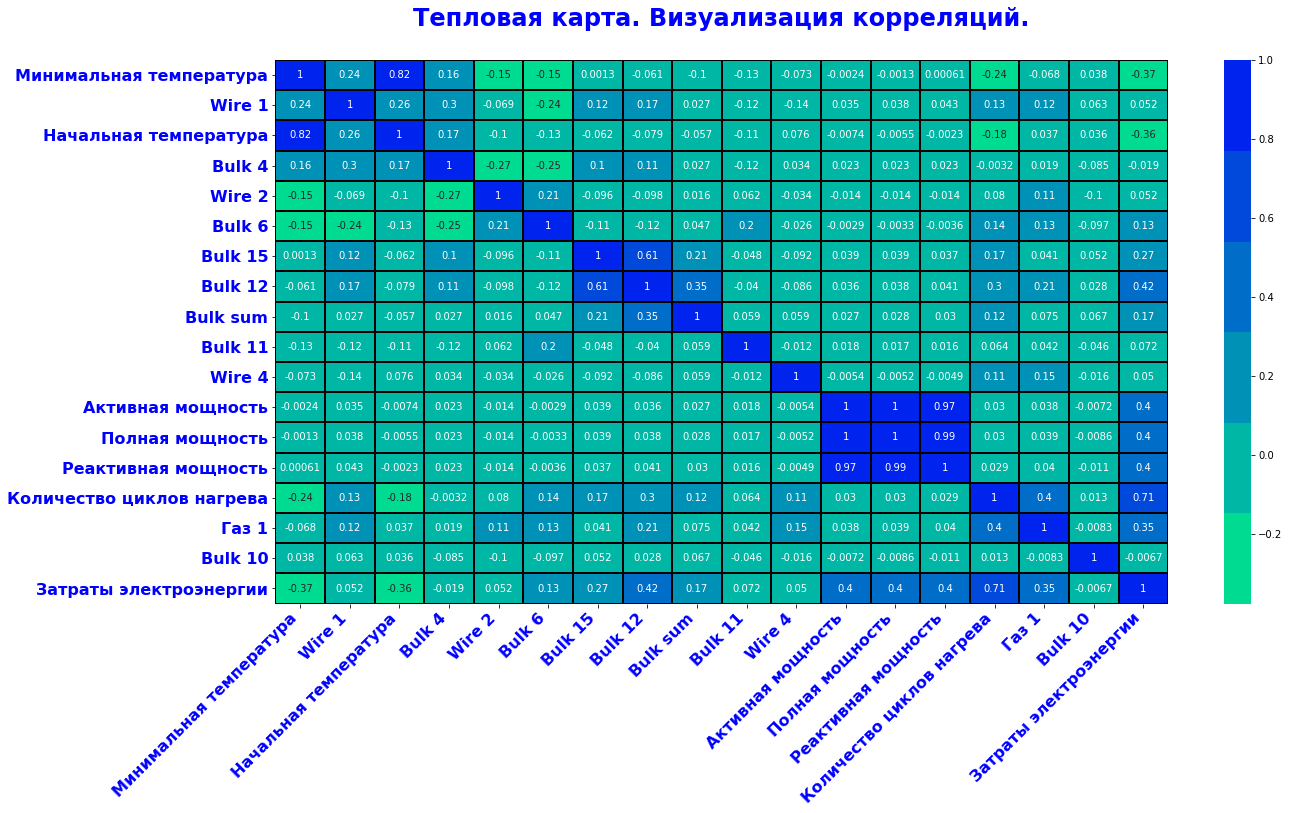

In [73]:
col = ['Минимальная температура',
       'Wire 1',
       'Начальная температура',
       'Bulk 4',
       'Wire 2',
       'Bulk 6',
       'Bulk 15',
       'Bulk 12',
       'Bulk sum',
       'Bulk 11',
       'Wire 4',
       'Активная мощность',
       'Полная мощность',
       'Реактивная мощность',
       'Количество циклов нагрева',
       'Газ 1',
       'Bulk 10',
       'Затраты электроэнергии'
      ]

file = total.loc[:, col ]
plt.figure(figsize=(20,10))
colormap = sns.color_palette("winter_r")
chart = sns.heatmap(file.corr(), annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title('Тепловая карта. Визуализация корреляций.\n ', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
plt.show()

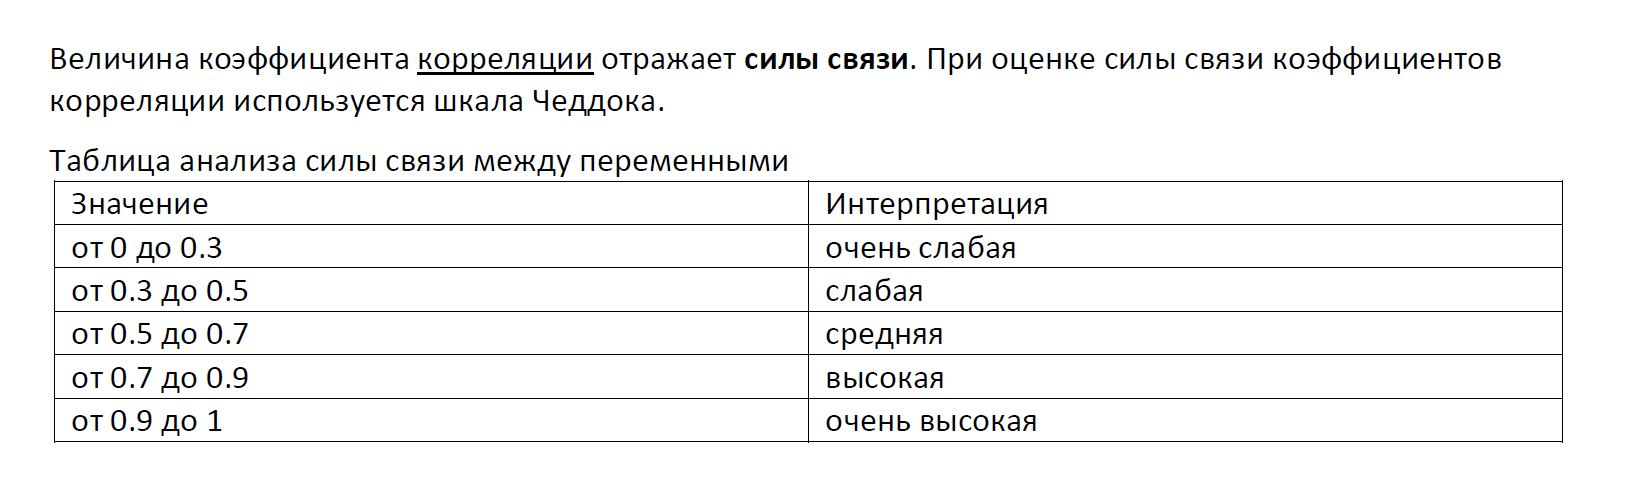

***Наблюдаем очень высокую корреляцию признаков активной, реактивной и полной мощности. Удалим перед обучением признаки реактивной и полной мощности, чтобы устранить мультиколлинеарность. Отметим, что высокая корреляция 0.82 между признаками начальной и минимальной температурой. Удалять не целесообразно.***

## Шаг 5: Подготовка данных

In [74]:
col = list(total)
print('\u001b[38;5;19m','Целевой признак: \n\n           Окончательная температура \n', '\u001b[0m')
del_col = ['Окончательная температура', 'Полная мощность', 'Реактивная мощность', 'key']

for value in del_col:
    col.remove(value)

print('\u001b[38;5;19m','Используемые для обучения признаки: \n', '\u001b[0m')
for i in col:
    print('\u001b[38;5;19m','         ', i, '\u001b[0m')

 Целевой признак: 

           Окончательная температура 
 
 Используемые для обучения признаки: 
 
           Количество циклов нагрева 
           Активная мощность 
           Время нагрева дугой 
           Затраты электроэнергии 
           Bulk 1 
           Bulk 2 
           Bulk 3 
           Bulk 4 
           Bulk 5 
           Bulk 6 
           Bulk 7 
           Bulk 8 
           Bulk 9 
           Bulk 10 
           Bulk 11 
           Bulk 12 
           Bulk 13 
           Bulk 14 
           Bulk 15 
           Bulk sum 
           Газ 1 
           Начальная температура 
           Минимальная температура 
           Wire 1 
           Wire 2 
           Wire 3 
           Wire 4 
           Wire 5 
           Wire 6 
           Wire 7 
           Wire 8 
           Wire 9 


In [75]:
X = total[col]
y = total['Окончательная температура']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

***Подготовили данные и разделили на 2 выборки train/test в соотношении 75/25 для дальнейшего обучения модели.***

## Шаг 6: Обучение моделей машинного обучения

### Линейная регрессия

In [76]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = pd.DataFrame(X_train_scaler, columns=X_train.columns)

In [77]:
model_lr = LinearRegression()
mae_lr = round(abs(cross_val_score(model_lr, X=X_train_scaler, y=y_train, cv=5, scoring='neg_mean_absolute_error')).mean(), 2)
print('\u001b[38;5;19m','MAE LinearRegression = ', mae_lr, '\u001b[0m')

 MAE LinearRegression =  5.32 


### «Случайный лес»

In [78]:
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [20, 25, 30],
    'min_samples_split': [2, 3, 4],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]
}
model_rf = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
model_rf.fit(X_train, y_train)
print('\u001b[38;5;19m', model_rf.best_params_, '\u001b[0m')

 {'bootstrap': True, 'max_depth': 30, 'min_samples_split': 3, 'n_estimators': 50, 'random_state': 42} 


In [79]:
mae_rf = round(abs(model_rf.best_score_), 2)
print('\u001b[38;5;19m','MAE RandomForestRegressor = ', mae_rf, '\u001b[0m')

 MAE RandomForestRegressor =  4.73 


### Модель CatBoost

In [80]:
model = CatBoostRegressor() 
parameters = [{'learning_rate':[0.06, 0.065, 0.07, 0.075, 0.08], 'random_state':[RANDOM_STATE], 'verbose':[False]}]
model_cbr = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
model_cbr.fit(X_train, y_train)
print('\u001b[38;5;19m', model_cbr.best_params_, '\u001b[0m')

 {'learning_rate': 0.07, 'random_state': 42, 'verbose': False} 


In [81]:
mae_cbr = round(abs(model_cbr.best_score_), 2)
print('\u001b[38;5;19m','MAE CatBoostRegressor = ', mae_cbr, '\u001b[0m')

 MAE CatBoostRegressor =  4.61 


###  Light Gradient Boosted Machine (LightGBM)

In [82]:
model = LGBMRegressor() 
parameters = [{'learning_rate':[0.03, 0.04, 0.05, 0.06, 0.07], 'max_depth': [15, 16, 17], 'random_state':[RANDOM_STATE]}]
model_lgbmr = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
model_lgbmr.fit(X_train, y_train)
print('\u001b[38;5;19m', model_lgbmr.best_params_, '\u001b[0m')

 {'learning_rate': 0.05, 'max_depth': 16, 'random_state': 42} 


In [83]:
mae_lgbmr = round(abs(model_lgbmr.best_score_), 2)
print('\u001b[38;5;19m','MAE LGBMRegressor = ', mae_lgbmr, '\u001b[0m')

 MAE LGBMRegressor =  4.62 


## Шаг 6: Выбор лучшей модели

In [84]:
data = {'MAE обучения, %':[mae_lr, mae_rf, mae_cbr, mae_lgbmr]}
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
data_final = pd.DataFrame(data=data, index=index)
pd.set_option('precision', 2)
display(data_final.sort_values(by='MAE обучения, %', ascending=True).style.background_gradient(cmap='Blues', axis=0))

,"MAE обучения, %"
CatBoostRegressor,4.61
LGBMRegressor,4.62
RandomForestRegressor,4.73
LinearRegression,5.32


In [85]:
model_cbr = CatBoostRegressor(learning_rate=0.06, random_state=RANDOM_STATE, verbose = False)
model_cbr.fit(X_train, y_train)
y_pred = model_cbr.predict(X_test)
mae_cbr = round(mean_absolute_error(y_test, y_pred), 2)
print('\u001b[38;5;19m','MAE CatBoostRegressor на тестовой выборке = ', mae_cbr, '\u001b[0m')

 MAE CatBoostRegressor на тестовой выборке =  4.61 


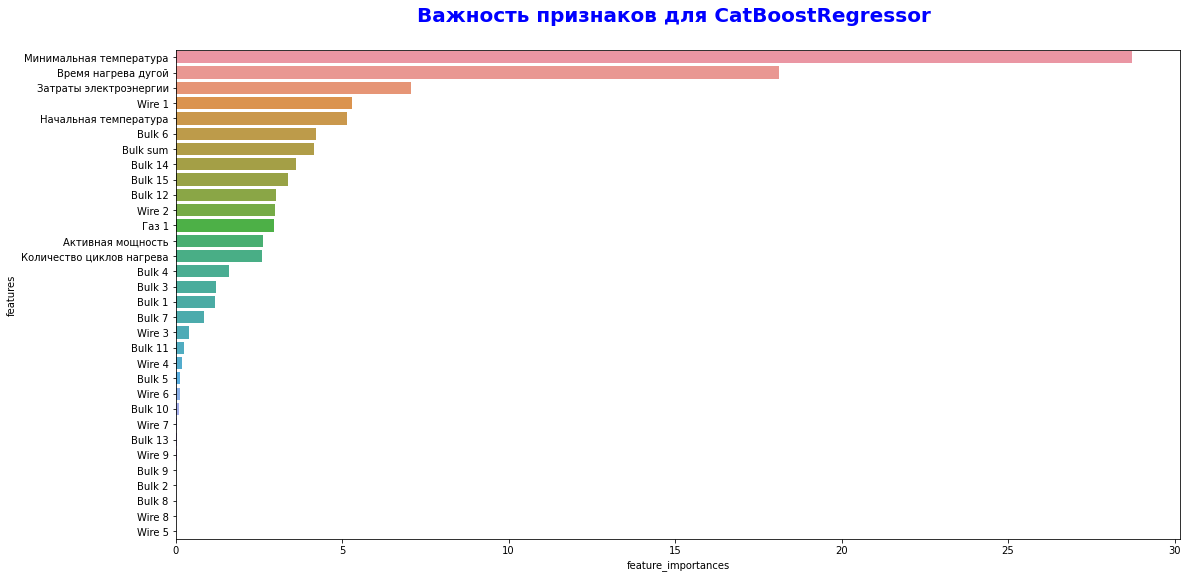

In [86]:
plot_data = {
    'features': X_test.columns,
    'feature_importances': model_cbr.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor \n', fontsize=20, fontweight="bold", color='blue')
plt.show()

***Наиболее значимыми признаками для модели CatBoostRegressor:***
- Минимальная температура
- Время нагрева дугой
- Затраты электроэнергии
- Wire 1
- Начальная температура
- Bulk 6
- Bulk sum (признак общего объема добавленного сыпучего материала)
- Bulk 14
- Bulk 12
- Wire 2
- Газ 1     (признак объема подаваемого газа)

## Шаг 7: Общий вывод и рекомендации заказчику

- Загрузили данные. Обработали пропуски и выбросы.
- Подтвердили корректность и наглядность в названиях столбцов.
- Добавили признаки `Количество циклов нагрева`, `Время нагрева дугой`, `Минимальная температура` и `Начальная температура`.
- Добавили признаки `Полная мощность` и `Затраты электроэнергии`, высчитанные по формуле.
- Добавили признак `Bulk sum` общего объема добавленного сыпучего материала.
- Удалили партии с начальной температурой ниже технологического регламента (1400°С).
- Удалили партии с пропусками в замерах температуры.
- По результату исследовательского анализа были удалены 27.7% исходных данных.
- Проверили на корректность времени определения температуры согласно регламенту.
- Целевым признаком по требованию заказчика является окончательная температура сплава.
- Провели корреляционные анализ с визуализацией корреляций. Выявели 3 признака сильно коррелирующие друг с другом. 
- Удалили признаки реактивной и полной мощности, чтобы устранить мультиколлинеарность.
- Подготовили данные и разделили на 2 выборки train/test в соотношении 75/25 для дальнейшего обучения модели.
- Проверили четыре модели: Линейная регрессия, «Случайный лес», CatBoostRegressor, LGBMRegressor.
- Лучший целевой показатель на тренировочных данных MAE=4.61 показала модель CatBoostRegressor.
- Показатель MAE для итоговой модели CatBoostRegressor на тестовых данных равен 4.61. То есть модель ошибается на ≈ 4,61 градуса.
- Получившийся результат проходит по условиям задачи MAE ≤ 6.8. 
- Исследовали важность признаков для модели CatBoostRegressor.
- Замечаем, что основные значимые признаки для этой модели были новыми добавленными признаками.
- Обученная модель CatBoostRegressor с подобранными гиперпараметрами рекомендована к использованию для прогнозирования температуры стали.